<a href="https://colab.research.google.com/github/yimingm/MSSP608-Practical-Machine-Learning/blob/master/Homework5_Annotation.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Homework 5 (Due February 27, 2020)

Last week you annotated a set of at least 200 microblog posts (your Training Set) with a supervised learning task designed by you and your partner, with your own annotation manual. 

By now, you should have two columns of labels for each post, and you should know the approximate upper bound of machine learning performance on this data, equal to your inter-rater reliability.

Save your work to a CSV file with the two annotator's labels (name the columns `labels_A` and `labels_B`), and a third column with the original text of the annotated post. 



In [ ]:
import math
import pandas as pd
import numpy as np
import statsmodels.formula.api as smf
import matplotlib.pyplot as plt
from scipy import stats
from matplotlib import dates
from datetime import datetime
import re
import calendar
import json

from sklearn.metrics import accuracy_score, precision_score, recall_score, cohen_kappa_score, confusion_matrix, f1_score, ConfusionMatrixDisplay
from sklearn.linear_model import LogisticRegression, SGDClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.naive_bayes import BernoulliNB, ComplementNB, GaussianNB, MultinomialNB 
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import LinearSVC, SVC
from sklearn import tree
from sklearn.model_selection import train_test_split, KFold, StratifiedKFold
from sklearn.feature_extraction.text import CountVectorizer,TfidfVectorizer

import spacy
from spacy.lang.en import English
from spacy.lang.zh import Chinese

import jieba
from sklearn.utils.testing import ignore_warnings
from sklearn.exceptions import ConvergenceWarning, UndefinedMetricWarning

from tqdm import tqdm
nlp = spacy.load('en_core_web_md', disable=["parser", "ner"])

/usr/local/lib/python3.6/dist-packages/sklearn/utils/deprecation.py:144: FutureWarning: The sklearn.utils.testing module is  deprecated in version 0.22 and will be removed in version 0.24. The corresponding classes / functions should instead be imported from sklearn.utils. Anything that cannot be imported from sklearn.utils is now part of the private API.
  warnings.warn(message, FutureWarning)


In [ ]:
!pip3 install https://github.com/explosion/spacy-models/releases/download/en_core_web_md-2.2.0/en_core_web_md-2.2.0.tar.gz

     |████████████████████████████████| 96.4MB 50.0MB/s 
  Created wheel for en-core-web-md: filename=en_core_web_md-2.2.0-cp36-none-any.whl size=98072934 sha256=502d362b513ade2ad1281eeec205c24d0094360de83816794ce1c611334cd1df
  Stored in directory: /root/.cache/pip/wheels/5f/3e/c9/36dd6e13b449fd84cd1f94b72dfbc559daf09f53dbf4e697a3
Successfully built en-core-web-md


# Upload and read the data



In [ ]:
!wget --no-check-certificate 'https://doc.google.com/uc?export=download&id=1bqTzJ46QR9hRXY-4Kd1c7R0EUIQ7wuOq' -O training_set.csv

--2020-02-28 02:00:04--  https://doc.google.com/uc?export=download&id=1bqTzJ46QR9hRXY-4Kd1c7R0EUIQ7wuOq
Resolving doc.google.com (doc.google.com)... 172.217.204.102, 172.217.204.139, 172.217.204.100, ...
Connecting to doc.google.com (doc.google.com)|172.217.204.102|:443... connected.
HTTP request sent, awaiting response... 301 Moved Permanently
Location: https://docs.google.com/uc?export=download&id=1bqTzJ46QR9hRXY-4Kd1c7R0EUIQ7wuOq [following]
--2020-02-28 02:00:04--  https://docs.google.com/uc?export=download&id=1bqTzJ46QR9hRXY-4Kd1c7R0EUIQ7wuOq
Resolving docs.google.com (docs.google.com)... 64.233.170.113, 64.233.170.102, 64.233.170.101, ...
Connecting to docs.google.com (docs.google.com)|64.233.170.113|:443... connected.
HTTP request sent, awaiting response... 302 Moved Temporarily
Location: https://doc-0c-6k-docs.googleusercontent.com/docs/securesc/ha0ro937gcuc7l7deffksulhg5h7mbp1/gcc8fjj2mu52rt07kprngkki5lvv5dsq/1582855200000/04766574434707070898/*/1bqTzJ46QR9hRXY-4Kd1c7R0EUIQ7wu

In [ ]:
twitter = pd.read_csv("training_set.csv")
print(twitter.head)

<bound method NDFrame.head of      labels_A  labels_B                                               text
0     neutral  negative  By George Aluo SUPER Eagles' Head Coach, Sunda...
1    positive  positive  Ed Sheeran live in DFW Sat night! Want in?? Ke...
2     neutral  negative  Re: last retweet: I've been thinking about thi...
3    positive  positive  Cate Blanchett isn't a tall poppy, she's a red...
4    negative  negative  Yo it's been 2 and a half weeks since Kendrick...
..        ...       ...                                                ...
195   neutral   neutral  Meatless Monday is promoted by Paul McCartney ...
196   neutral   neutral  Follow the top David Bowie stories for Nov 02 ...
197  positive  positive                                             #NAME?
198  negative  negative  It should put her in federal prison for life, ...
199  positive  positive  I just think when Shawn dances to his own musi...

[200 rows x 3 columns]>


## Task 1
The data was divided into a training set and a test set. Since the data was randomly chosen from the raw dataset and is unordered, it is resonable to cut the data directly. 

In [ ]:
# naive split
# The cutoff is 20% of the data set
test_set_percentage = 0.2
test_set_size = int(len(twitter)*test_set_percentage) 
test_cutoff = len(twitter) - test_set_size 

# Take everything before the cutoff to be the train set
twitter_train = twitter[:test_cutoff]

# Take everything after the cutoff to be the test set 
twitter_test = twitter[test_cutoff:]

# After the split, there is 160 data in training set and 40 data in test set
print("Size of train data:", len(twitter_train))
print("Size of test  data:", len(twitter_test))
print(twitter_train.head())

Size of train data: 160
Size of test  data: 40
   labels_A  labels_B                                               text
0   neutral  negative  By George Aluo SUPER Eagles' Head Coach, Sunda...
1  positive  positive  Ed Sheeran live in DFW Sat night! Want in?? Ke...
2   neutral  negative  Re: last retweet: I've been thinking about thi...
3  positive  positive  Cate Blanchett isn't a tall poppy, she's a red...
4  negative  negative  Yo it's been 2 and a half weeks since Kendrick...


# Task 2

Following five optimizations were performed:

   - Compare Naïve Bayes, Logistic Regression, and SVMs on a unigram feature space.
   - Compare a unigram feature space with a feature space that also includes longer N-grams.
   - Compare a unigram feature space with a feature space that removes stopwords.
   - Vary the vocabulary size of your n-gram feature space and evaluate how performance changes.
   - Compare an n-gram feature space with a feature space that also includes part-of-speech n-grams.

The performance of the best-tuned model on the cross-validated training set are in the following tables.


![alt text](https://drive.google.com/uc?id=1ZuUWKNmXXx3M86Gqyxi91fZZLQ40vT9j)

![alt text](https://drive.google.com/uc?id=1kgi3RLtQSKlSC182biZ6WN2kcO7NhAJY)

##1. Compare Naïve Bayes, Logistic Regression, and SVMs on a unigram feature space.

In [ ]:
# Define a function to evaluate a classifier's predictions
def evaluate(y_pred, y_actual, metrics, model_name = 'model'):
    # Compute Confusion Matrix
    conf_matrix = confusion_matrix(y_actual, y_pred)

    # Compute and store each metric
    model_metrics = {}
    for (metric_name, metric) in metrics.items():
        result = metric(y_actual, y_pred)
        model_metrics[metric_name] = result

    return conf_matrix, model_metrics

# Define a function that trains a classifier and evaluates it on one fold
def evaluate_one_fold(classifier_name, classifier, X_train, y_train, X_test, y_test, metrics, fold_num, noisy = 'loud', labels=[]):

    # Train and Evaluate Model
    model = classifier.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    conf_matrix, model_metrics = evaluate(y_pred, y_test, metrics, model_name = classifier_name)

    # Display Results appropriately when noisy is set to 'loud' or 'quiet'
    if noisy == 'quiet' and fold_num == 0:
        print(f"{classifier_name}: Fold {fold_num}", end = '')
    elif noisy == 'quiet':
        print(f'...{fold_num}', end ='')
    elif noisy == 'loud':
        print(f"{classifier_name}: Fold {fold_num} Results")
        ConfusionMatrixDisplay(conf_matrix, labels).plot(values_format='.4g')
        plt.show()
        print(model_metrics)
        print("------------------------")

    return model_metrics

# Define a function to evaluate over all folds
def evaluate_all_folds(classifier_name, classifier, X, y, kf, metrics, noisy = 'loud', labels=[]):

    # Initialize tracking variables
    all_fold_metrics = {metric_name: [] for metric_name in metrics}

    # Iterate over each fold
    for fold_num, (train_index, test_index) in enumerate(kf.split(X, y)):
        # Get the data subset for the current fold
        X_train = X.iloc[train_index]
        X_test = X.iloc[test_index]
        y_train = y.iloc[train_index]
        y_test = y.iloc[test_index]

        # Train and Evaluate the Model
        model_metrics =  evaluate_one_fold(classifier_name, classifier, X_train, y_train, X_test, y_test, metrics, fold_num, noisy, labels=labels)

        # Update our tracking variables
        [all_fold_metrics[metric_name].append(metric_val) for metric_name, metric_val in model_metrics.items()]

    return all_fold_metrics

@ignore_warnings(category=ConvergenceWarning)
@ignore_warnings(category=UndefinedMetricWarning)

# Define a function to compare different classifiers
def compare_classifiers(classifiers, metrics, metrics_to_show, metric_to_optimize, df, feature_set,
                        target, folds = 10, shuffle = True, noisy='loud', labels=[]):
    # Initialize tracking variables
    best = 0
    best_name = None
    classifier_comparison = {}

    # Set up dataset and cross validation
    X = df.loc[:, feature_set]
    X = pd.get_dummies(X)
    y = df[target]
    kf = StratifiedKFold(n_splits=folds, shuffle=shuffle, random_state=123)

    # For each classifier
    for classifier_name, classifier in classifiers.items():
        # Evaluate on all metrics for all 10 folds
        all_fold_metrics = evaluate_all_folds(classifier_name, classifier, X, y, kf, metrics, noisy = noisy, labels=labels)

        # Compute average performance on metric to optimize over
        optimization_metric_avg = np.mean(all_fold_metrics[metric_to_optimize])
        show_metric_avg = np.mean(all_fold_metrics[metrics_to_show])

        # Update Tracking Variables
        if optimization_metric_avg > best:
            best = optimization_metric_avg
            best_name = classifier_name
        classifier_comparison[classifier_name] = all_fold_metrics
        if noisy == 'quiet': 
            print()
            print(f"Average {metrics_to_show}:{show_metric_avg:.4f}")
            print(f"Average {metric_to_optimize}: {optimization_metric_avg:.3f}")
            print('-------------')
    # Return our results
    return best, best_name, classifier_comparison
    

In [ ]:
# Define unigrams baseline
def ngrams(column, vocab_size = 1000, min_n=1, max_n=1):
  vectorizer = CountVectorizer(max_features=vocab_size, ngram_range=(1,max_n))
  X = vectorizer.fit_transform(column)

  bow_df = pd.DataFrame(X.toarray())
  column_names = [str(i) for i in range(vocab_size)]
  for k, v in vectorizer.vocabulary_.items():
    column_names[v] = k
  bow_df.columns = column_names
  return column_names, bow_df

unigram_names, unigram_twitter_train = ngrams(twitter_train["text"], vocab_size = 1000, min_n=1, max_n=1)
unigram_twitter_train["labels_A"] = twitter_train["labels_A"]


unigram_twitter_train

,0x3oseqznr,12,12th,13,13th,14,14th,15,16th,17,18th,1927,1943,1953,1st,2001,2015,2020,22,23,24,25,29,2gether,2nd,2night,30,30pm,30th,36,3bxkidrsoq,3pm,3rd,3x,484uavkl39,4afu3nbz2x,4th,500th,501st,54,...,win,winning,with,without,won,wonder,work,worked,worshipped,worst,would,wouldn,wright,write,writes,wrong,wrs,wt9kgpsrrj,xjnoafohuw,xnsm1nzagg,yakub,yeah,year,years,yes,yesterday,yet,yfoa4i09ex,ygcz8pny4a,ykhfqbyfow,yo,yoga,you,youngromans,your,yr,zac,zayn,zivndh6mce,labels_A
0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,neutral
1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,positive
2,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,neutral
3,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,positive
4,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,1,0,0,0,0,0,0,0,0,negative
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
155,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,positive
156,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,negative
157,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,neutral
158,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,negative


In [ ]:
# Pick Classifiers to Compare
classifiers = {
    "Complement NB": ComplementNB(),
    "Logistic Regression": LogisticRegression(),
    "Linear SVM": LinearSVC()
}
# Set a list of metrics we want to use to compare our classifiers 
metrics = {
    "Accuracy" : lambda y,y_pred: 100*accuracy_score(y,y_pred),
    "Kappa"    : cohen_kappa_score
}

# Choose a metric to show
metrics_to_show = "Accuracy"

# Choose a metric to optimize over
metric_to_optimize = 'Kappa'

# Pick features to use
feature_set = unigram_names

sorted_sentiments = ["negative", "neutral", "positive"]

# Compare models and display final result
best, best_name, classifier_comparison = compare_classifiers(classifiers, metrics, metrics_to_show, metric_to_optimize, unigram_twitter_train, feature_set, "labels_A", labels=sorted_sentiments, noisy = 'quiet',)

print(f"Best classifier is: {best_name} \nWith K={best:.3f}. ")    


Complement NB: Fold 0...1...2...3...4...5...6...7...8...9
Average Accuracy:42.5000
Average Kappa: 0.097
-------------
Logistic Regression: Fold 0...1...2...3...4...5...6...7...8...9
Average Accuracy:48.1250
Average Kappa: 0.080
-------------
Linear SVM: Fold 0...1...2...3...4...5...6...7...8...9
Average Accuracy:45.0000
Average Kappa: 0.061
-------------
Best classifier is: Complement NB 
With K=0.097. 


##2. Compare a unigram feature space with a feature space that also includes longer N-grams.

In [ ]:
# DataFrame of Bigrams
bigram_names, bigram_twitter_train = ngrams(twitter_train["text"], vocab_size = 1000, max_n=2)
bigram_twitter_train["labels_A"] = twitter_train["labels_A"]

# DataFrame of Trigrams
trigram_names, trigram_twitter_train = ngrams(twitter_train["text"], vocab_size = 1000, max_n=3)
trigram_twitter_train["labels_A"] = twitter_train["labels_A"]
print(trigram_twitter_train.iloc[:5])

   12th  13  15  16th  ...  you stare directly  you want  your  labels_A
0     0   0   0     0  ...                   0         0     0   neutral
1     0   0   0     0  ...                   0         0     0  positive
2     0   0   0     0  ...                   0         0     0   neutral
3     0   0   0     0  ...                   0         0     0  positive
4     0   0   0     0  ...                   0         0     0  negative

[5 rows x 1001 columns]


In [ ]:
### Setup classifiers and metrics to be used on all n-grams
# Pick Classifiers to Compare

classifiers = {
    "Complement NB": ComplementNB(),
    "Logistic Regression": LogisticRegression(),
    "Linear SVM": LinearSVC()
}
# Set a list of metrics we want to use to compare our classifiers 
metrics = {
    "Accuracy" : lambda y,y_pred: 100*accuracy_score(y,y_pred),
    "Kappa"    : cohen_kappa_score
}

# Choose a metric to show
metrics_to_show = "Accuracy"

# Choose a metric to optimize over
metric_to_optimize = 'Kappa'

### Compare classifiers on unigrams ###

best, best_name, classifier_comparison = compare_classifiers(classifiers, metrics, metrics_to_show, metric_to_optimize, unigram_twitter_train, unigram_names, "labels_A", labels=sorted_sentiments, noisy = 'quiet')

print(f"Unigram classifier K={best:.3f}.")    

### Compare classifiers on bigrams ###

# Compare models and display final result
best, best_name, classifier_comparison = compare_classifiers(classifiers, metrics, metrics_to_show, metric_to_optimize, bigram_twitter_train, bigram_names, "labels_A", labels=sorted_sentiments, noisy = 'quiet')

print(f"Bigram classifier K={best:.3f}.")    

### Compare classifiers on trigrams ###

feature_set = list(trigram_twitter_train.columns[:-2])

# Compare models and display final result
best, best_name, classifier_comparison = compare_classifiers(classifiers, metrics, metrics_to_show, metric_to_optimize, trigram_twitter_train, trigram_names, "labels_A", labels=sorted_sentiments, noisy = 'quiet')

print(f"Trigram classifier K={best:.3f}.") 

Complement NB: Fold 0...1...2...3...4...5...6...7...8...9
Average Accuracy:42.5000
Average Kappa: 0.097
-------------
Logistic Regression: Fold 0...1...2...3...4...5...6...7...8...9
Average Accuracy:48.1250
Average Kappa: 0.080
-------------
Linear SVM: Fold 0...1...2...3...4...5...6...7...8...9
Average Accuracy:45.0000
Average Kappa: 0.061
-------------
Unigram classifier K=0.097.
Complement NB: Fold 0...1...2...3...4...5...6...7...8...9
Average Accuracy:40.6250
Average Kappa: 0.075
-------------
Logistic Regression: Fold 0...1...2...3...4...5...6...7...8...9
Average Accuracy:45.0000
Average Kappa: 0.052
-------------
Linear SVM: Fold 0...1...2...3...4...5...6...7...8...9
Average Accuracy:45.0000
Average Kappa: 0.067
-------------
Bigram classifier K=0.075.
Complement NB: Fold 0...1...2...3...4...5...6...7...8...9
Average Accuracy:38.7500
Average Kappa: 0.051
-------------
Logistic Regression: Fold 0...1...2...3...4...5...6...7...8...9
Average Accuracy:43.1250
Average Kappa: 0.032
---

##3. Compare a unigram feature space with a feature space that removes stopwords

In [ ]:
# Extract features for unigrams with no stopwords included.
vectorizer = CountVectorizer(max_features=1000, ngram_range=(1,1), stop_words='english')
X = vectorizer.fit_transform(twitter_train["text"])

no_stopwords_twitter_train = pd.DataFrame(X.toarray())
no_stopwords_columns = [str(i) for i in range(1000)]
for k, v in vectorizer.vocabulary_.items():
  no_stopwords_columns[v] = k
no_stopwords_twitter_train.columns = no_stopwords_columns
no_stopwords_twitter_train["labels_A"] = twitter_train["labels_A"]


In [ ]:
unigram_twitter_train["labels_A"] = twitter_train["labels_A"]

# Re-run classifier with stopwords included, as a baseline.
best, best_name, classifier_comparison = compare_classifiers(classifiers, metrics, metrics_to_show, metric_to_optimize, unigram_twitter_train, unigram_names, "labels_A", labels=sorted_sentiments, noisy = 'quiet')

print(f"Classifier with stopwords K={best:.3f}.")    

# Run classifier on the feature space with stopwords removed.
best, best_name, classifier_comparison = compare_classifiers(classifiers, metrics, metrics_to_show, metric_to_optimize, no_stopwords_twitter_train, no_stopwords_columns, "labels_A", labels=sorted_sentiments, noisy = 'quiet')

print(f"Classifier without stopwords K={best:.3f}.")   

# Run classifier on the feature space with case-sensitive unigrams.
#best, best_name, classifier_comparison = compare_classifiers(classifiers, metrics, metrics_to_show, metric_to_optimize, case_sensitive_twitter_train, case_sensitive_columns, "labels_A", labels=sorted_sentiments, noisy = 'quiet')

#print(f"Classifier with case-sensitive unigrams K={best:.3f}.")   


Complement NB: Fold 0...1...2...3...4...5...6...7...8...9
Average Accuracy:42.5000
Average Kappa: 0.097
-------------
Logistic Regression: Fold 0...1...2...3...4...5...6...7...8...9
Average Accuracy:48.1250
Average Kappa: 0.080
-------------
Linear SVM: Fold 0...1...2...3...4...5...6...7...8...9
Average Accuracy:45.0000
Average Kappa: 0.061
-------------
Classifier with stopwords K=0.097.
Complement NB: Fold 0...1...2...3...4...5...6...7...8...9
Average Accuracy:34.3750
Average Kappa: 0.042
-------------
Logistic Regression: Fold 0...1...2...3...4...5...6...7...8...9
Average Accuracy:46.2500
Average Kappa: 0.032
-------------
Linear SVM: Fold 0...1...2...3...4...5...6...7...8...9
Average Accuracy:45.6250
Average Kappa: 0.053
-------------
Classifier without stopwords K=0.053.


##4. Vary the vocabulary size of n-gram feature space

In [ ]:
# Change the vocabulary size of unigram baseline from 1000 to 500
def ngrams(column, vocab_size = 500, min_n=1, max_n=1):
  vectorizer = CountVectorizer(max_features=vocab_size, ngram_range=(1,max_n))
  X = vectorizer.fit_transform(column)

  bow_df = pd.DataFrame(X.toarray())
  column_names = [str(i) for i in range(vocab_size)]
  for k, v in vectorizer.vocabulary_.items():
    column_names[v] = k
  bow_df.columns = column_names
  return column_names, bow_df

unigram_names, unigram_twitter_train = ngrams(twitter_train["text"], vocab_size = 500, min_n=1, max_n=1)
unigram_twitter_train["labels_A"] = twitter_train["labels_A"]


unigram_twitter_train

,12th,13,15,16th,1st,23,2nd,30,3rd,4th,5th,9th,about,add,after,again,against,aldean,all,already,am,amp,amy,an,and,announcement,ant,are,around,as,at,august,back,band,bat,be,because,been,before,believe,...,why,will,win,winning,with,wonder,work,worked,worshipped,worst,would,wouldn,wright,write,writes,wrong,wrs,wt9kgpsrrj,xjnoafohuw,xnsm1nzagg,yakub,yeah,year,years,yes,yesterday,yet,yfoa4i09ex,ygcz8pny4a,ykhfqbyfow,yo,yoga,you,youngromans,your,yr,zac,zayn,zivndh6mce,labels_A
0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,neutral
1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,positive
2,0,0,0,0,0,0,0,0,0,0,0,0,2,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,neutral
3,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,positive
4,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,2,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,1,0,0,0,0,0,0,0,0,negative
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
155,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,positive
156,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,negative
157,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,2,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,neutral
158,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,negative


In [ ]:
# Pick Classifiers to Compare

classifiers = {
    "Complement NB": ComplementNB(),
    "Logistic Regression": LogisticRegression(),
    "Linear SVM": LinearSVC()
}
# Set a list of metrics to compare classifiers 
metrics = {
    "Accuracy" : lambda y,y_pred: 100*accuracy_score(y,y_pred),
    "Kappa"    : cohen_kappa_score
}

# Choose a metric to show
metrics_to_show = "Accuracy"

# Choose a metric to optimize over
metric_to_optimize = 'Kappa'

# Pick features to use
feature_set = unigram_names

sorted_sentiments = ["negative", "neutral", "positive"]

# Compare models and display final result
best, best_name, classifier_comparison = compare_classifiers(classifiers, metrics, metrics_to_show, metric_to_optimize, unigram_twitter_train, feature_set, "labels_A", labels=sorted_sentiments, noisy = 'quiet',)

print(f"Best classifier is: {best_name} \nWith K={best:.3f}.")    


Complement NB: Fold 0...1...2...3...4...5...6...7...8...9
Average Accuracy:44.3750
Average Kappa: 0.118
-------------
Logistic Regression: Fold 0...1...2...3...4...5...6...7...8...9
Average Accuracy:45.6250
Average Kappa: 0.051
-------------
Linear SVM: Fold 0...1...2...3...4...5...6...7...8...9
Average Accuracy:40.0000
Average Kappa: -0.003
-------------
Best classifier is: Complement NB 
With K=0.118.


##5. Compare an n-gram feature space with a feature space that also includes part-of-speech n-grams.

In [ ]:
# Compute POS tagging using Spacy
nlp = spacy.load('en_core_web_md', disable=["parser", "ner"])

def tokenize(nlp, row):
    text = row["text"]
    tokens = nlp(text)
    return tokens

%time all_tagged = twitter_train.apply(lambda x: tokenize(nlp, x), axis=1)
twitter_train["tokenized"] = all_tagged

CPU times: user 690 ms, sys: 3.7 ms, total: 693 ms
Wall time: 700 ms


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  if __name__ == '__main__':


In [ ]:
# Print the first 2 messages
print(twitter_train["tokenized"].iloc[0])
print(twitter_train["tokenized"].iloc[1])
print()

# As well as their POS tagging
for i in [0, 1]:
  for token in twitter_train["tokenized"].iloc[i]:
    print(token.text.ljust(10), end='')
  print()
  for token in twitter_train["tokenized"].iloc[i]:
    print(token.lemma_.ljust(10), end='')
  print()
  for token in twitter_train["tokenized"].iloc[i]:
    print(token.pos_.ljust(10), end='')
  print()
  for token in twitter_train["tokenized"].iloc[i]:
    print(token.tag_.ljust(10), end='')
  print("\n-------------------------------------------------------------------------------------------------")


By George Aluo SUPER Eagles' Head Coach, Sunday Oliseh, has declared that he is con- demned to winning next... http://t.co/LkhjoO07sW
Ed Sheeran live in DFW Sat night! Want in?? Keep track of the 5 songs for DFW's Most Wanted at 8p and I'll throw you a pair of tix! -Cruz

By        George    Aluo      SUPER     Eagles    '         Head      Coach     ,         Sunday    Oliseh    ,         has       declared  that      he        is        con-      demned    to        winning   next      ...       http://t.co/LkhjoO07sW
by        George    Aluo      SUPER     Eagles    '         Head      Coach     ,         Sunday    Oliseh    ,         have      declare   that      -PRON-    be        con-      demned    to        win       next      ...       http://t.co/LkhjoO07sW
ADP       PROPN     PROPN     PROPN     PROPN     PART      PROPN     PROPN     PUNCT     PROPN     PROPN     PUNCT     AUX       VERB      SCONJ     PRON      AUX       NOUN      ADJ       ADP       VERB      ADV       P

In [ ]:
# Create a string of the POS features for each sentence
pos_strings = []
for row in twitter_train["tokenized"]:
    pos_strings.append(" ".join([token.tag_ for token in row]))

print("Example of POS Features")
print(pos_strings[0])
print()

# Get the unigram representation of the POS features
column_names, pos_twitter_train = ngrams(pos_strings, vocab_size = 480, min_n=2, max_n=2)

# Add classification features
pos_twitter_train["labels_A"] = twitter_train["labels_A"]

# Preview the dataframe
print("Preview POS unigram dataframe")
pos_twitter_train

Example of POS Features
IN NNP NNP NNP NNPS POS NNP NNP , NNP NNP , VBZ VBN IN PRP VBZ NN JJ IN VBG RB : NNP

Preview POS unigram dataframe


,_sp,_sp cd,_sp dt,_sp nn,_sp nnp,_sp prp,_sp rb,_sp vb,_sp vbd,_sp vbp,add,add cc,add in,add nfp,add nn,add nnp,add uh,cc,cc cd,cc dt,cc in,cc jj,cc nfp,cc nn,cc nnp,cc nns,cc prp,cc rb,cc uh,cc vb,cc vbd,cc vbg,cc vbp,cd,cd _sp,cd cc,cd dt,cd hyph,cd in,cd nn,...,vbz md,vbz nn,vbz nnp,vbz nns,vbz pdt,vbz prp,vbz rb,vbz rp,vbz to,vbz uh,vbz vb,vbz vbd,vbz vbg,vbz vbn,vbz wp,wdt,wdt nn,wdt nnp,wp,wp dt,wp md,wp nn,wp nnp,wp prp,wp rp,wp vbd,wp vbp,wp vbz,wrb,wrb dt,wrb jj,wrb md,wrb nnp,wrb nns,wrb prp,wrb vbd,wrb vbg,wrb vbp,xx,labels_A
0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,1,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,neutral
1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,1,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,positive
2,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,2,0,0,0,0,1,0,0,0,0,0,neutral
3,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,positive
4,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,2,0,1,0,0,0,0,0,0,1,0,0,0,0,0,0,1,0,1,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,negative
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
155,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,positive
156,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,1,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,negative
157,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,2,1,0,0,0,0,0,0,0,0,0,0,1,0,0,0,3,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,neutral
158,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,2,0,0,0,0,2,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,negative


In [ ]:
unigram_names, unigram_twitter_train = ngrams(twitter_train["text"], vocab_size = 500, min_n=1, max_n=1)
pos_bigram_names, pos_bigram_twitter_train = ngrams(pos_strings, vocab_size = 480, min_n=2, max_n=2)

combined_bigram_twitter_train = unigram_twitter_train.merge(pos_bigram_twitter_train, how="left", left_index=True, right_index=True)
combined_bigram_twitter_train["labels_A"] = twitter_train["labels_A"]

pos_trigram_names, pos_trigram_twitter_train = ngrams(pos_strings, vocab_size = 480, min_n=2, max_n=3)

combined_trigram_twitter_train = unigram_twitter_train.merge(pos_trigram_twitter_train, how="left", left_index=True, right_index=True)
combined_trigram_twitter_train["labels_A"] = twitter_train["labels_A"]



In [ ]:
# Pick Classifiers to Compare
classifiers = {
    "Complement NB": ComplementNB()
}

# Set a list of metrics we want to use to compare our classifiers 
metrics = {
    "Accuracy" : lambda y,y_pred: 100*accuracy_score(y,y_pred),
    "Kappa"    : cohen_kappa_score
}

# Choose a metric to show
metrics_to_show = "Accuracy"

# Choose a metric to optimize over
metric_to_optimize = 'Kappa'

sorted_sentiments = ["negative", "neutral", "positive"]

# Pick features to use
feature_set = list(combined_bigram_twitter_train.columns[:-2])

# Compare models and display final result
best, best_name, classifier_comparison = compare_classifiers(classifiers, metrics, metrics_to_show, metric_to_optimize, combined_bigram_twitter_train, feature_set, "labels_A", labels=sorted_sentiments, noisy = 'quiet')

print(f"Classifier with Unigrams + POS Bigrams K={best:.3f}.")    

# Pick features to use
feature_set = list(combined_trigram_twitter_train.columns[:-2])

# Compare models and display final result
best, best_name, classifier_comparison = compare_classifiers(classifiers, metrics, metrics_to_show, metric_to_optimize, combined_trigram_twitter_train, feature_set, "labels_A", labels=sorted_sentiments, noisy = 'quiet')

print(f"Classifier with Unigrams + POS Bigrams and Trigrams K={best:.3f}.")    



Complement NB: Fold 0...1...2...3...4...5...6...7...8...9
Average Accuracy:43.7500
Average Kappa: 0.100
-------------
Classifier with Unigrams + POS Bigrams K=0.100.
Complement NB: Fold 0...1...2...3...4...5...6...7...8...9
Average Accuracy:41.8750
Average Kappa: 0.074
-------------
Classifier with Unigrams + POS Bigrams and Trigrams K=0.074.


# Task 3

Train two models, each **trained on the full 80% training set, and tested on the held-out 20% test set**:
   - A Naïve Bayes classifier with unigram features.
   - The best-tuned model from task two, retrained on the full 80% training set. 
   
The performance of the two models, along with the performance from Task 2 are in the table below:
   - Although the vocabulary size of 500 outperformed vocabulary size of 1000 in Task 2, when test on the 20% test set in Task 3, 1000 vocabulary size has higher Kappa (0.1579) and accuracy (45).
   - The same model has slighly different performance when test on different dataset. The best-tuned model from Task 2 has higher Kappa and accuracy when test on cross-validated training set than on the held-out 20% test set.


![alt text](https://drive.google.com/uc?id=149xZRjwca3DXP4KnKn3BjA5D31PzrV8j)

Model 1 - A Naïve Bayes classifier with unigram features.

Train on the full 80% training set, test on held-out 20% test set:


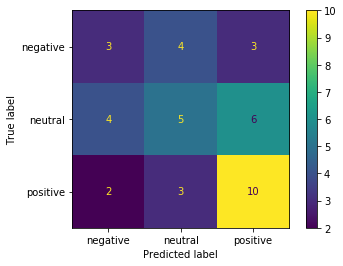

{'Accuracy': 45.0, 'Kappa': 0.1578947368421053}
------------------------


In [ ]:
combined_unigram_names,combined_unigram_df = ngrams(twitter["text"], vocab_size = 1000, min_n=1, max_n=1)
combined_unigram_df["labels_A"] = twitter["labels_A"]
feature_set = list(combined_unigram_df.columns[:-1])

test_set_percentage = 0.2
test_set_size = int(len(combined_unigram_df)*test_set_percentage) 
test_cutoff = len(combined_unigram_df) - test_set_size 

# Take everything before the cutoff to be the train set
training_set = combined_unigram_df[:test_cutoff]

# Take everything after the cutoff to be the test set 
test_set = combined_unigram_df[test_cutoff:]

# Train on posts, test on replies
X_train = training_set.loc[:, feature_set]
X_train = pd.get_dummies(X_train)
y_train = training_set["labels_A"]

X_test = test_set.loc[:, feature_set]
X_test = pd.get_dummies(X_test)
y_test = test_set["labels_A"]

classifier = ComplementNB()
# Train and Evaluate Model
model = classifier.fit(X_train, y_train)

y_pred = model.predict(X_test)
conf_matrix, model_metrics = evaluate(y_pred, y_test, metrics, model_name = "Naive Bayes")

print(f"Train on the full 80% training set, test on held-out 20% test set:")
ConfusionMatrixDisplay(conf_matrix, sorted_sentiments).plot(values_format='.4g')
plt.show()
print(model_metrics)
print("------------------------")

Model 2 - The best-tuned model from task two, retrained on the full 80% training set. A Naïve Bayes classifier with unigram features, using 500 vocabulary size.

Train on the full 80% training set, test on held-out 20% test set:


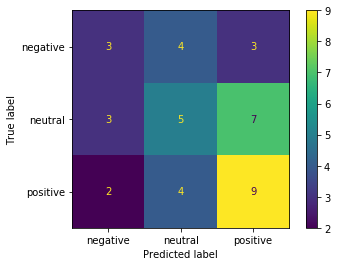

{'Accuracy': 42.5, 'Kappa': 0.11538461538461542}
------------------------


In [ ]:
combined_unigram_names,combined_unigram_df = ngrams(twitter["text"], vocab_size = 500, min_n=1, max_n=1)
combined_unigram_df["labels_A"] = twitter["labels_A"]
feature_set = list(combined_unigram_df.columns[:-1])

test_set_percentage = 0.2
test_set_size = int(len(combined_unigram_df)*test_set_percentage) 
test_cutoff = len(combined_unigram_df) - test_set_size 

# Take everything before the cutoff to be the train set
training_set = combined_unigram_df[:test_cutoff]

# Take everything after the cutoff to be the test set 
test_set = combined_unigram_df[test_cutoff:]

# Train on posts, test on replies
X_train = training_set.loc[:, feature_set]
X_train = pd.get_dummies(X_train)
y_train = training_set["labels_A"]

X_test = test_set.loc[:, feature_set]
X_test = pd.get_dummies(X_test)
y_test = test_set["labels_A"]

classifier = ComplementNB()
# Train and Evaluate Model
model = classifier.fit(X_train, y_train)

y_pred = model.predict(X_test)
conf_matrix, model_metrics = evaluate(y_pred, y_test, metrics, model_name = "Naive Bayes")

print(f"Train on the full 80% training set, test on held-out 20% test set:")
ConfusionMatrixDisplay(conf_matrix, sorted_sentiments).plot(values_format='.4g')
plt.show()
print(model_metrics)
print("------------------------")


# Scoring Rubric
![](https://drive.google.com/uc?export=view&id=1JqI8Tfmi3YrnjVdDxjwNu1ZOuOOgQCuI)

![](https://drive.google.com/uc?export=view&id=1VfVuKGmNBu6oJgXBTX4YB6Lxe_0t9cWN)